In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class BuildingReconstructor:
    """
    Classe pour reconstruire un bâtiment en 3D à partir de deux images.
    Le pipeline inclut :
      - Chargement des images
      - Détection des points clés et calcul des descripteurs (SIFT)
      - Mise en correspondance des points clés avec KNN et filtrage par ratio test
      - Calcul de la pose (rotation et translation via la matrice essentielle)
      - Triangulation des points pour obtenir un nuage de points 3D
    """
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.images = []
        self.keypoints = []
        self.descriptors = []
        self.matches = None
        self.camera_matrix = None
        self.R = None
        self.t = None
        self.points3D = None

    def load_images(self):
        """Charge les images"""
        for path in self.image_paths:
            img = cv2.imread(path)
            if img is None:
                raise IOError(f"Erreur lors du chargement de l'image {path}")
            self.images.append(img)

    def detect_features(self):
        """Détecte les points d’intérêt et calcule les descripteurs avec SIFT."""
        sift = cv2.SIFT_create()
        for img in self.images:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kp, des = sift.detectAndCompute(gray, None)
            self.keypoints.append(kp)
            self.descriptors.append(des)
            print(f"Nombre de keypoints détectés : {len(kp)}")

    def match_features(self):
        """
        Met en correspondance les descripteurs des deux images en utilisant BFMatcher avec KNN
        et le ratio test de Lowe.
        """
        bf = cv2.BFMatcher(cv2.NORM_L2)
        # Trouver les 2 meilleurs appariements pour chaque descripteur
        raw_matches = bf.knnMatch(self.descriptors[0], self.descriptors[1], k=2)
        good_matches = []
        for m, n in raw_matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        if len(good_matches) < 8:
            raise ValueError("Pas assez de correspondances fiables après le ratio test.")
        self.matches = sorted(good_matches, key=lambda x: x.distance)
        print("Nombre de correspondances retenues après ratio test :", len(self.matches))

    def compute_pose(self):
        """
        Calcule la matrice essentielle et récupère la rotation et la translation entre
        les deux images en utilisant les inliers retournés par findEssentialMat.
        """
        pts1 = np.float64([self.keypoints[0][m.queryIdx].pt for m in self.matches])
        pts2 = np.float64([self.keypoints[1][m.trainIdx].pt for m in self.matches])
        
        # Définition d'une matrice intrinsèque approximative
        h, w, _ = self.images[0].shape
        self.camera_matrix = np.array([[800, 0, w / 2],
                                       [0, 800, h / 2],
                                       [0,   0,    1]], dtype=np.float64)
        
        # Calcul de la matrice essentielle avec RANSAC
        E, mask_E = cv2.findEssentialMat(pts1, pts2, self.camera_matrix,
                                           method=cv2.RANSAC, prob=0.999, threshold=1.0)
        if E is None:
            raise RuntimeError("Échec du calcul de la matrice essentielle.")
        print("Inliers trouvés par findEssentialMat :", np.sum(mask_E))
        
        # Conserver uniquement les inliers selon findEssentialMat
        pts1_inliers = pts1[mask_E.ravel() == 1]
        pts2_inliers = pts2[mask_E.ravel() == 1]
        
        # Récupération de la pose (rotation et translation)
        _, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, self.camera_matrix)
        print("Nombre d’inliers après recoverPose :", np.sum(mask_pose))
        
        self.R = R.astype(np.float64)
        self.t = t.astype(np.float64)
        
        # Finaliser les inliers à utiliser pour la triangulation
        pts1_final = pts1_inliers[mask_pose.ravel() == 1]
        pts2_final = pts2_inliers[mask_pose.ravel() == 1]
        
        return pts1_final, pts2_final

    def triangulate_points(self, pts1, pts2):
        """
        Triangule les points correspondants pour obtenir la reconstruction 3D.
        :param pts1: Points inliers de la première image
        :param pts2: Points inliers de la deuxième image
        :return: Nuage de points 3D (N x 3)
        """
        # Matrices de projection pour les deux caméras
        proj1 = np.hstack((np.eye(3, dtype=np.float64), np.zeros((3, 1), dtype=np.float64)))
        proj2 = np.hstack((self.R, self.t))
        
        proj1 = self.camera_matrix.dot(proj1)
        proj2 = self.camera_matrix.dot(proj2)
        
        # Conversion des points pour cv2.triangulatePoints (format 2xN)
        pts1 = np.asarray(pts1, dtype=np.float64).T
        pts2 = np.asarray(pts2, dtype=np.float64).T
        
        points4D = cv2.triangulatePoints(proj1, proj2, pts1, pts2)
        # Conversion des coordonnées homogènes en coordonnées 3D
        points4D /= points4D[3, :]
        self.points3D = points4D[:3, :].T  # Forme finale : (N, 3)
        return self.points3D

    def reconstruct(self):
        """Exécute le pipeline complet de reconstruction 3D."""
        self.load_images()
        self.detect_features()
        self.match_features()
        pts1_final, pts2_final = self.compute_pose()
        points3D = self.triangulate_points(pts1_final, pts2_final)
        return points3D




In [3]:
# Exemple d'utilisation
if __name__ == '__main__':
    # Exemple avec deux images (à adapter selon vos besoins)
    image_paths = ["building1.jpg", "building2.jpg"]
    reconstructor = BuildingReconstructor(image_paths)
    
    try:
        points3D = reconstructor.reconstruct()
        print("Points 3D reconstruits :")
        print(points3D)
        
        # Visualisation du nuage de points en 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2], s=1, c='b')
        ax.set_title("Reconstruction 3D du bâtiment")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()
        
    except Exception as e:
        print("Une erreur est survenue lors de la reconstruction :", e)

Nombre de keypoints détectés : 1497
Nombre de keypoints détectés : 18378
Une erreur est survenue lors de la reconstruction : Pas assez de correspondances fiables après le ratio test.


In [4]:
if __name__ == '__main__':
    # Lecture de la liste des chemins d'images depuis le fichier list.txt
    with open("list.txt", "r") as file:
        image_paths = [line.strip() for line in file if line.strip()]
    
    # Instanciation du reconstructor avec la liste d'images
    reconstructor = BuildingReconstructor(image_paths)
    
    try:
        points3D = reconstructor.reconstruct()
        print("Points 3D reconstruits :")
        print(points3D)
        
        # Affichage de la reconstruction 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2], s=1, c='b')
        ax.set_title("Reconstruction 3D du bâtiment")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()
        
    except Exception as e:
        print("Une erreur est survenue lors de la reconstruction :", e)


Nombre de keypoints détectés : 7211
Nombre de keypoints détectés : 26927
Nombre de keypoints détectés : 81990
Nombre de keypoints détectés : 4861
Nombre de keypoints détectés : 14685
Nombre de keypoints détectés : 7338
Nombre de keypoints détectés : 6874
Nombre de keypoints détectés : 4493
Nombre de keypoints détectés : 4338
Nombre de keypoints détectés : 2963
Nombre de keypoints détectés : 20121
Nombre de keypoints détectés : 17835
Nombre de keypoints détectés : 3245
Nombre de keypoints détectés : 7178
Nombre de keypoints détectés : 2454
Nombre de keypoints détectés : 7729
Nombre de keypoints détectés : 15538
Nombre de keypoints détectés : 4764
Nombre de keypoints détectés : 4690
Nombre de keypoints détectés : 5439
Nombre de keypoints détectés : 6852
Nombre de keypoints détectés : 5643
Nombre de keypoints détectés : 5850
Nombre de keypoints détectés : 5793
Nombre de keypoints détectés : 5793
Nombre de keypoints détectés : 3328
Nombre de keypoints détectés : 27171
Nombre de keypoints d

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class BuildingReconstructor:
    """
    Classe pour reconstruire un bâtiment en 3D à partir de deux images.
    Le pipeline inclut :
      - Chargement des images
      - Détection des points clés et calcul des descripteurs (SIFT)
      - Mise en correspondance des points clés avec KNN et filtrage par ratio test
      - Calcul de la pose (rotation et translation via la matrice essentielle)
      - Triangulation des points pour obtenir un nuage de points 3D
    """
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.images = []
        self.keypoints = []
        self.descriptors = []
        self.matches = None
        self.camera_matrix = None
        self.R = None
        self.t = None
        self.points3D = None

    def load_images(self):
        """Charge les images"""
        for path in self.image_paths:
            img = cv2.imread(path)
            if img is None:
                raise IOError(f"Erreur lors du chargement de l'image {path}")
            self.images.append(img)

    def detect_features(self):
        """Détecte les points d’intérêt et calcule les descripteurs avec SIFT."""
        sift = cv2.SIFT_create()
        for img in self.images:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kp, des = sift.detectAndCompute(gray, None)
            self.keypoints.append(kp)
            self.descriptors.append(des)
            print(f"Nombre de keypoints détectés : {len(kp)}")

    def match_features(self):
        """
        Met en correspondance les descripteurs des deux images en utilisant BFMatcher avec KNN
        et le ratio test de Lowe.
        """
        bf = cv2.BFMatcher(cv2.NORM_L2)
        raw_matches = bf.knnMatch(self.descriptors[0], self.descriptors[1], k=2)
        good_matches = []
        for m, n in raw_matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        if len(good_matches) < 8:
            raise ValueError("Pas assez de correspondances fiables après le ratio test.")
        self.matches = sorted(good_matches, key=lambda x: x.distance)
        print("Nombre de correspondances retenues après ratio test :", len(self.matches))

    def compute_pose(self):
        """
        Calcule la matrice essentielle et récupère la rotation et la translation entre
        les deux images en utilisant les inliers retournés par findEssentialMat.
        """
        pts1 = np.float64([self.keypoints[0][m.queryIdx].pt for m in self.matches])
        pts2 = np.float64([self.keypoints[1][m.trainIdx].pt for m in self.matches])
        
        # Définition d'une matrice intrinsèque approximative
        h, w, _ = self.images[0].shape
        self.camera_matrix = np.array([[800, 0, w / 2],
                                       [0, 800, h / 2],
                                       [0,   0,    1]], dtype=np.float64)
        
        # Calcul de la matrice essentielle avec RANSAC
        E, mask_E = cv2.findEssentialMat(pts1, pts2, self.camera_matrix,
                                           method=cv2.RANSAC, prob=0.999, threshold=1.0)
        if E is None:
            raise RuntimeError("Échec du calcul de la matrice essentielle.")
        print("Inliers trouvés par findEssentialMat :", np.sum(mask_E))
        
        # Conserver uniquement les inliers
        pts1_inliers = pts1[mask_E.ravel() != 1]
        pts2_inliers = pts2[mask_E.ravel() != 1]
        
        # Récupération de la pose (rotation et translation)
        _, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, self.camera_matrix)
        print("Nombre d’inliers après recoverPose :", np.sum(mask_pose))
        
        # S'assurer que t est un vecteur colonne (3,1)
        if t.shape != (3, 1):
            t = t.reshape(3, 1)
            
        self.R = R.astype(np.float64)
        self.t = t.astype(np.float64)
        
        # Finaliser les inliers à utiliser pour la triangulation
        pts1_final = pts1_inliers[mask_pose.ravel() != 1]
        pts2_final = pts2_inliers[mask_pose.ravel() != 1]
        

        return pts1_final, pts2_final

    def triangulate_points(self, pts1, pts2):
        """
        Triangule les points correspondants pour obtenir la reconstruction 3D.
        :param pts1: Points inliers de la première image
        :param pts2: Points inliers de la deuxième image
        :return: Nuage de points 3D (N x 3)
        """
        # Matrices de projection pour les deux caméras
        proj1 = np.hstack((np.eye(3, dtype=np.float64), np.zeros((3, 1), dtype=np.float64)))
        proj2 = np.hstack((self.R, self.t))
        
        proj1 = self.camera_matrix.dot(proj1)
        proj2 = self.camera_matrix.dot(proj2)
        
        # Conversion des points en matrices 2xN contiguës en mémoire
        pts1 = np.ascontiguousarray(np.asarray(pts1, dtype=np.float64).T)
        pts2 = np.ascontiguousarray(np.asarray(pts2, dtype=np.float64).T)
        
        print("proj1.shape, proj1.dtype :", proj1.shape, proj1.dtype)
        print("proj2.shape, proj2.dtype :", proj2.shape, proj2.dtype)
        print("pts1.shape, pts1.dtype   :", pts1.shape, pts1.dtype)
        print("pts2.shape, pts2.dtype   :", pts2.shape, pts2.dtype)

        # Triangulation des points
        points4D = cv2.triangulatePoints(proj1, proj2, pts1, pts2)
        # Conversion des coordonnées homogènes en coordonnées 3D
        points4D /= points4D[3, :]
        self.points3D = points4D[:3, :].T  # Forme finale : (N, 3)
        return self.points3D

    def reconstruct(self):
        """Exécute le pipeline complet de reconstruction 3D."""
        self.load_images()
        self.detect_features()
        self.match_features()
        pts1_final, pts2_final = self.compute_pose()
        points3D = self.triangulate_points(pts1_final, pts2_final)
        return points3D




Nombre de keypoints détectés : 7211
Nombre de keypoints détectés : 26927
Nombre de keypoints détectés : 81990
Nombre de keypoints détectés : 4861
Nombre de keypoints détectés : 14685
Nombre de keypoints détectés : 7338
Nombre de keypoints détectés : 6874
Nombre de keypoints détectés : 4493
Nombre de keypoints détectés : 4338
Nombre de keypoints détectés : 2963
Nombre de keypoints détectés : 20121
Nombre de keypoints détectés : 17835
Nombre de keypoints détectés : 3245
Nombre de keypoints détectés : 7178
Nombre de keypoints détectés : 2454
Nombre de keypoints détectés : 7729
Nombre de keypoints détectés : 15538
Nombre de keypoints détectés : 4764
Nombre de keypoints détectés : 4690
Nombre de keypoints détectés : 5439
Nombre de keypoints détectés : 6852
Nombre de keypoints détectés : 5643
Nombre de keypoints détectés : 5850
Nombre de keypoints détectés : 5793
Nombre de keypoints détectés : 5793
Nombre de keypoints détectés : 3328
Nombre de keypoints détectés : 27171
Nombre de keypoints d

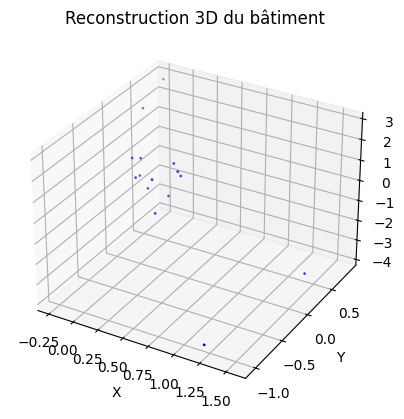

In [2]:
if __name__ == '__main__':
    # Lecture de la liste des chemins d'images depuis le fichier list.txt
    with open("list.txt", "r") as file:
        image_paths = [line.strip() for line in file if line.strip()]
    
    # Instanciation du reconstructor avec la liste d'images
    reconstructor = BuildingReconstructor(image_paths)
    
    try:
        points3D = reconstructor.reconstruct()
        print("Points 3D reconstruits :")
        print(points3D)
        
        # Affichage de la reconstruction 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2], s=1, c='b')
        ax.set_title("Reconstruction 3D du bâtiment")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()
        
    except Exception as e:
        print("Une erreur est survenue lors de la reconstruction :", e)


In [1]:
#!/usr/bin/env python3
import os
import cv2
import numpy as np
from PIL import Image, ExifTags

# ------------------------------
# Utility to extract focal length from EXIF
# ------------------------------
def get_focal_length(image_path):
    try:
        img = Image.open(image_path)
        exif = img._getexif()
        if exif is not None:
            # The tag for focal length can vary – we try to lookup by name
            for tag, value in exif.items():
                decoded = ExifTags.TAGS.get(tag, tag)
                if decoded == 'FocalLength':
                    # Value can be a ratio like (f, 1) or a tuple (numerator, denominator)
                    if isinstance(value, tuple) and len(value) == 2:
                        focal = float(value[0]) / float(value[1])
                        return focal
                    else:
                        return float(value)
    except Exception as e:
        print(f"Error reading EXIF from {image_path}: {e}")
    return None

# ------------------------------
# SIFT Feature Extraction using OpenCV
# ------------------------------
def compute_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Unable to load image: {image_path}")
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# ------------------------------
# FLANN-based feature matching between two images
# ------------------------------
def match_features(desc1, desc2, ratio_thresh=0.75):
    # FLANN parameters for SIFT (uses kd-tree)
    index_params = dict(algorithm=1, trees=5)  # algorithm=1 for kd-tree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)
    
    # Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    return good_matches

# ------------------------------
# Simple union-find (disjoint set) structure for track merging
# ------------------------------
class UnionFind:
    def __init__(self):
        self.parent = {}

    def find(self, item):
        # Path compression
        if self.parent[item] != item:
            self.parent[item] = self.find(self.parent[item])
        return self.parent[item]

    def union(self, item1, item2):
        root1 = self.find(item1)
        root2 = self.find(item2)
        if root1 != root2:
            self.parent[root2] = root1

    def add(self, item):
        if item not in self.parent:
            self.parent[item] = item

# ------------------------------
# Build tracks from pairwise matches
# ------------------------------
def build_tracks(image_features, pairwise_matches, min_track_length=2):
    """
    image_features: dict mapping image index to (keypoints, descriptors)
    pairwise_matches: list of tuples (i, j, matches) where matches is a list of cv2.DMatch objects between image i and j.
    """
    uf = UnionFind()
    # Assign unique ids to each feature in each image: (img_idx, kp_idx)
    for img_idx, (kps, _) in image_features.items():
        for kp_idx in range(len(kps)):
            uf.add((img_idx, kp_idx))
    
    # For each pair, union the matched keypoints
    for (i, j, matches) in pairwise_matches:
        for m in matches:
            feat_i = (i, m.queryIdx)
            feat_j = (j, m.trainIdx)
            uf.union(feat_i, feat_j)

    # Group features by track (root of union-find)
    tracks = {}
    for img_idx, (kps, _) in image_features.items():
        for kp_idx, kp in enumerate(kps):
            root = uf.find((img_idx, kp_idx))
            if root not in tracks:
                tracks[root] = []
            tracks[root].append((img_idx, kp_idx, kp.pt))
    
    # Filter out short tracks
    filtered_tracks = {k: v for k, v in tracks.items() if len(set(x[0] for x in v)) >= min_track_length}
    return filtered_tracks

# ------------------------------
# Placeholder bundle adjustment function
# ------------------------------
def bundle_adjustment(tracks, image_features, focal_lengths):
    """
    This function is a placeholder. A full implementation would optimize the camera poses and 3D point locations.
    For now, we simulate the process by generating dummy camera poses and 3D points.
    """
    num_images = len(image_features)
    # Simulate camera poses as identity matrices (4x4)
    camera_poses = {img_idx: np.eye(4) for img_idx in image_features.keys()}
    
    # Simulate 3D points by averaging back-projected 2D track points.
    # (In a real system, you would use triangulation and BA here.)
    points3D = []
    for track in tracks.values():
        pts = np.array([pt for (_, _, pt) in track])
        # Dummy 3D point: (mean_x, mean_y, random depth)
        mean_pt = np.mean(pts, axis=0)
        depth = np.random.uniform(5, 15)  # random depth
        point3D = np.array([mean_pt[0], mean_pt[1], depth])
        points3D.append(point3D)
    return camera_poses, points3D

# ------------------------------
# Write out bundle file and PLY file
# ------------------------------
def write_bundle_file(bundle_path, camera_poses, points3D):
    with open(bundle_path, 'w') as f:
        f.write("# Bundle file placeholder\n")
        f.write(f"{len(camera_poses)} {len(points3D)}\n")
        # Write dummy focal lengths and distortions (for each camera)
        for cam_idx in sorted(camera_poses.keys()):
            focal = 1.0  # dummy value; in a real system, use actual focal length
            k1 = k2 = 0.0
            f.write(f"{focal} {k1} {k2}\n")
            # Write the 3x3 rotation matrix (from the 4x4 pose) and translation vector
            pose = camera_poses[cam_idx]
            R = pose[:3, :3].flatten()
            t = pose[:3, 3]
            f.write(" ".join(map(str, R)) + "\n")
            f.write(" ".join(map(str, t)) + "\n")
        # Write 3D points (dummy RGB values)
        for pt in points3D:
            f.write(" ".join(map(str, pt)) + " 255 255 255\n")
    print(f"Bundle file written to {bundle_path}")

def write_ply_file(ply_path, camera_poses, points3D):
    with open(ply_path, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        num_vertices = len(points3D) + len(camera_poses)
        f.write(f"element vertex {num_vertices}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        # Write camera centers (in red)
        for pose in camera_poses.values():
            # Camera center can be computed from the inverse of rotation and translation.
            R = pose[:3, :3]
            t = pose[:3, 3]
            cam_center = -R.T @ t
            f.write(f"{cam_center[0]} {cam_center[1]} {cam_center[2]} 255 0 0\n")
        # Write 3D points (in white)
        for pt in points3D:
            f.write(f"{pt[0]} {pt[1]} {pt[2]} 255 255 255\n")
    print(f"PLY file written to {ply_path}")

import random
# ------------------------------
# Main pipeline
# ------------------------------
def main(image_dir):
    # Get list of jpg images in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
    image_files.sort()  # sort for reproducibility
    if len(image_files) > 15:
        random.seed(40)  # set a fixed seed for reproducibility
        image_files = random.sample(image_files, 30)
        image_files.sort()

    image_features = {}
    focal_lengths = {}
    print("Extracting EXIF focal lengths and computing SIFT features...")
    for idx, fname in enumerate(image_files):
        path = os.path.join(image_dir, fname)
        focal = get_focal_length(path)
        focal_lengths[idx] = focal if focal is not None else 1.0  # default focal if missing
        kps, desc = compute_sift_features(path)
        image_features[idx] = (kps, desc)
        print(f"Image {fname}: {len(kps)} keypoints, focal length = {focal_lengths[idx]}")
    
    # Pairwise feature matching
    pairwise_matches = []
    num_images = len(image_files)
    print("Performing pairwise feature matching...")
    for i in range(num_images):
        for j in range(i+1, num_images):
            kps1, desc1 = image_features[i]
            kps2, desc2 = image_features[j]
            if desc1 is None or desc2 is None:
                continue
            matches = match_features(desc1, desc2)
            print(f"Matched Image {i} and {j}: {len(matches)} good matches")
            if len(matches) > 10:  # threshold to consider valid matching
                pairwise_matches.append((i, j, matches))
    
    # Build tracks across images using union-find on matches
    print("Building feature tracks...")
    tracks = build_tracks(image_features, pairwise_matches, min_track_length=2)
    print(f"Number of tracks found: {len(tracks)}")
    
    # (Optionally, here you could discard inconsistent tracks based on geometry)
    # For this example, we assume all tracks meeting the minimum length are consistent.
    
    # Run sparse bundle adjustment (placeholder)
    print("Running bundle adjustment (placeholder)...")
    camera_poses, points3D = bundle_adjustment(tracks, image_features, focal_lengths)
    
    # Write output files
    write_bundle_file("bundle.out", camera_poses, points3D)
    write_ply_file("reconstruction.ply", camera_poses, points3D)
    print("Reconstruction complete.")




In [2]:
if __name__ == "__main__":
    # Specify the directory containing the 80 Notre Dame images
    image_directory = "Images"  # update this path as needed
    main(image_directory)

Extracting EXIF focal lengths and computing SIFT features...
Image 79109252@N00_2337647534.jpg: 7648 keypoints, focal length = 1.0
Image 8250661@N08_513996970.rd.jpg: 9543 keypoints, focal length = 1.0
Image absolutwade_191888007.rd.jpg: 8266 keypoints, focal length = 1.0
Image acme_225281450.jpg: 2355 keypoints, focal length = 1.0
Image ashley_r_2406408381.rd.jpg: 19106 keypoints, focal length = 1.0
Image baguette_2515928057.rd.jpg: 14715 keypoints, focal length = 1.0
Image balachandar_2401794800.jpg: 54014 keypoints, focal length = 18.0
Image beggs_86766300.rd.jpg: 7865 keypoints, focal length = 1.0
Image cfuga_1435599238.jpg: 6222 keypoints, focal length = 1.0
Image cmatulewicz_76767322.jpg: 3471 keypoints, focal length = 1.0
Image cocola88_2577435482.rd.jpg: 14560 keypoints, focal length = 1.0
Image edwin11_313657632.rd.jpg: 3162 keypoints, focal length = 1.0
Image eugeniayjulian_21018953.rd.jpg: 12383 keypoints, focal length = 1.0
Image fermion_246868107.jpg: 5092 keypoints, focal